## Advanced Lane Line Detection Laboratory

In this notebook, a pipeline of advanced lane line detection algorithm will be developed and experimented.

In [1]:
# Packages import
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
import glob
%matplotlib inline

### Step 0 - Show Test Image

In [2]:
import os
Imag_dir = "../test_images/"
TestImag_list = os.listdir(Imag_dir)

test_images = []
for i in range (8):
    image = mpimg.imread(Imag_dir + TestImag_list[i])
    test_images.append(image)

Height,Width,channel = test_images[1].shape
print(Height,Width,channel)

720 1280 3


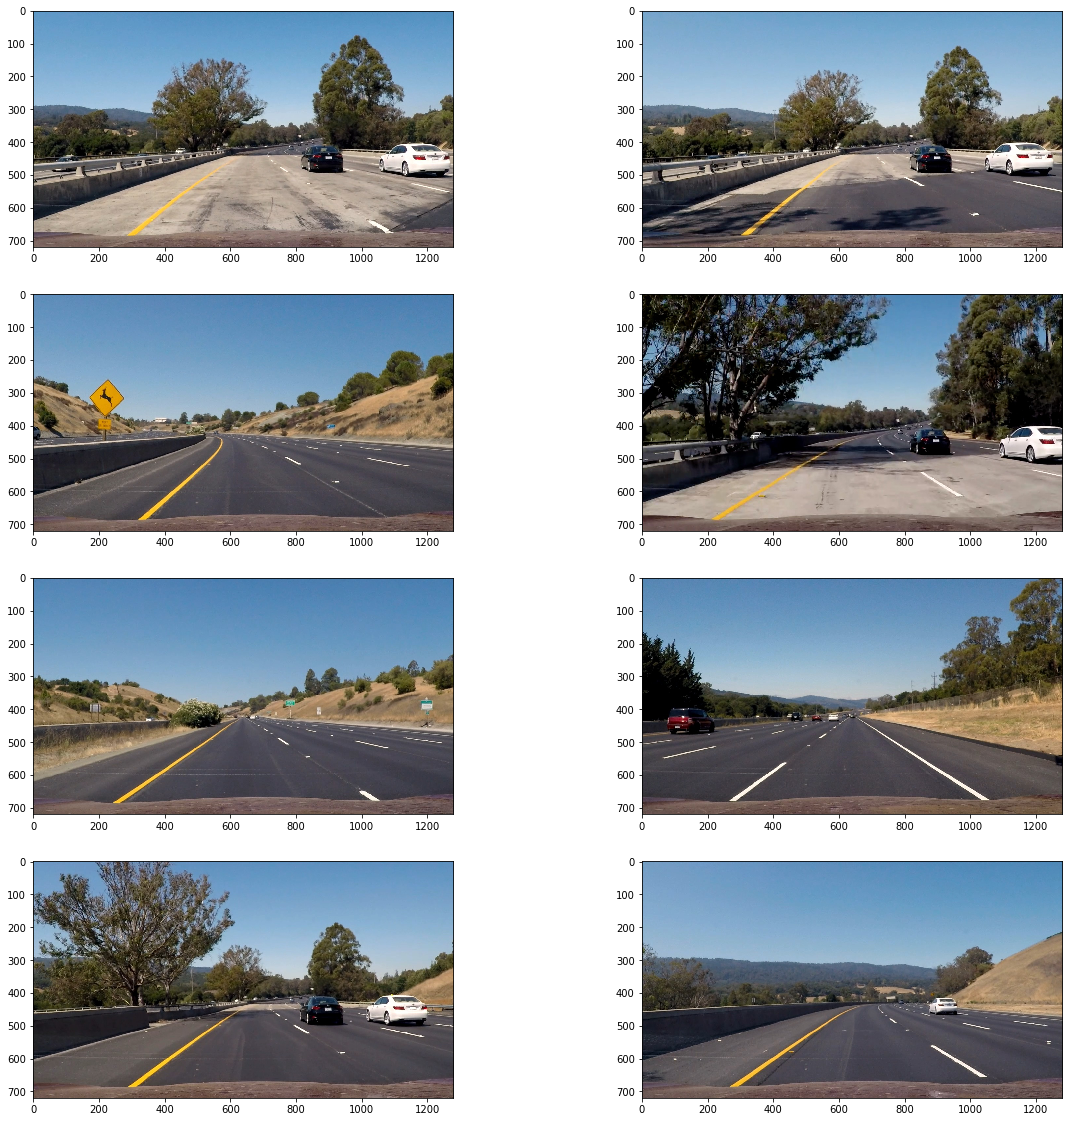

In [6]:
fig = plt.figure(figsize = (20,20))
for i in range (8):
    ax = fig.add_subplot(4,2,i+1)
    ax.imshow(test_images[i])
    

### Step 1 - Camera Calibration

#### Preparing Calibration Points

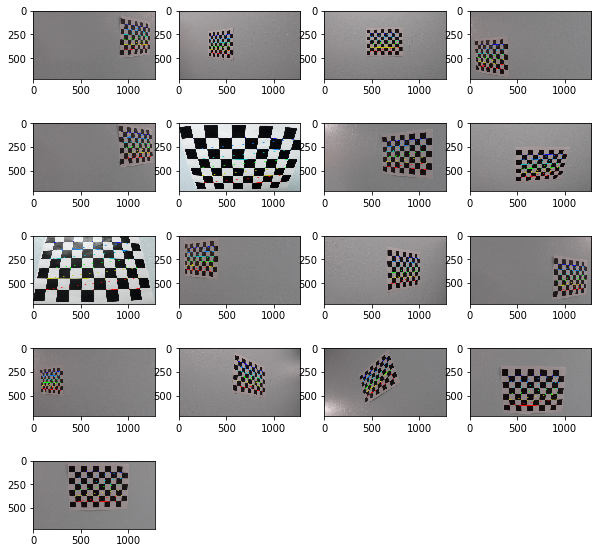

In [41]:
#-------------Prepare for the chessboard images-------------
chessbImages = glob.glob("../camera_cal/calibration*.jpg")

#--------------going through each image to obtain the imagepoints and objectpoints--------------
imagespoints = []
objectpoints = []
cornerImag = []

# preload the object points
objp = np.zeros((6*9,3),np.float32)
objp[:,0:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # generate an array with each row containing (x,y,z) for each conner

# looping through each image
for fname in chessbImages:
    img = cv2.imread(fname)
    
    # convert to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # find chessboard corner
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # If found, draw corners
    if ret == True:
        imagespoints.append(corners)
        objectpoints.append(objp)
        cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        cornerImag.append(img)
        
# show the chessboard images with corners marked 
fig = plt.figure(figsize = (10,10))
for i in range (len(cornerImag)):
    ax = fig.add_subplot(4,5,i+1)
    ax.imshow(cornerImag[i])

#### Calculate the Correction Matrix

In [70]:
img = cv2.imread("../camera_cal/calibration1.jpg")
imag_size = (img.shape[1],img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectpoints, imagespoints, imag_size, None, None)

# Save the camera calibration result
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ))

Now, we can try some images to see how the calibration works

Text(0.5, 1.0, 'undistorted image')

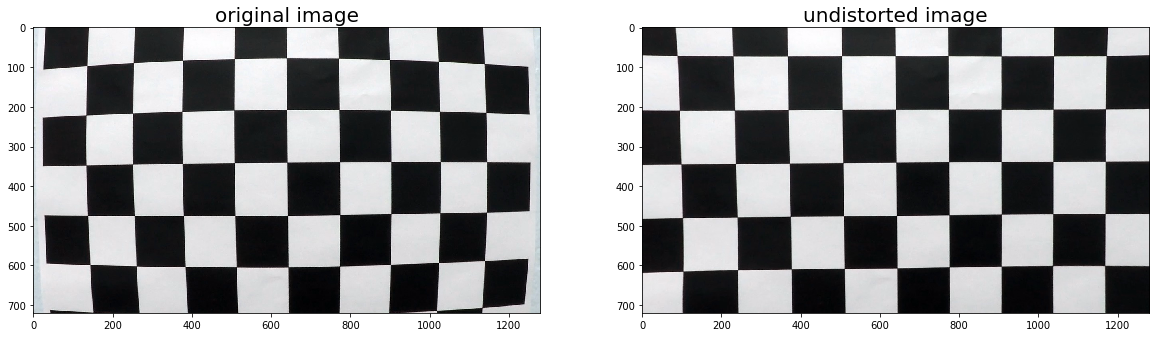

In [69]:
img = cv2.imread("../camera_cal/calibration1.jpg")
dst = cv2.undistort(img, mtx, dist, None, mtx)

f,(ax1,ax2) = plt.subplots(1, 2, figsize = (20,10))
ax1.imshow(img)
ax1.set_title("original image", fontsize = 20)
ax2.imshow(dst)
ax2.set_title("undistorted image", fontsize = 20)

### Step 2 - Undistort the Images

In [3]:
# Read in the saved undistortion matrix
dist_pickle = pickle.load( open( "calibration.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

undisImag = []
for i in range (8):
    undisImag.append(cv2.undistort(test_images[i], mtx, dist, None, mtx))

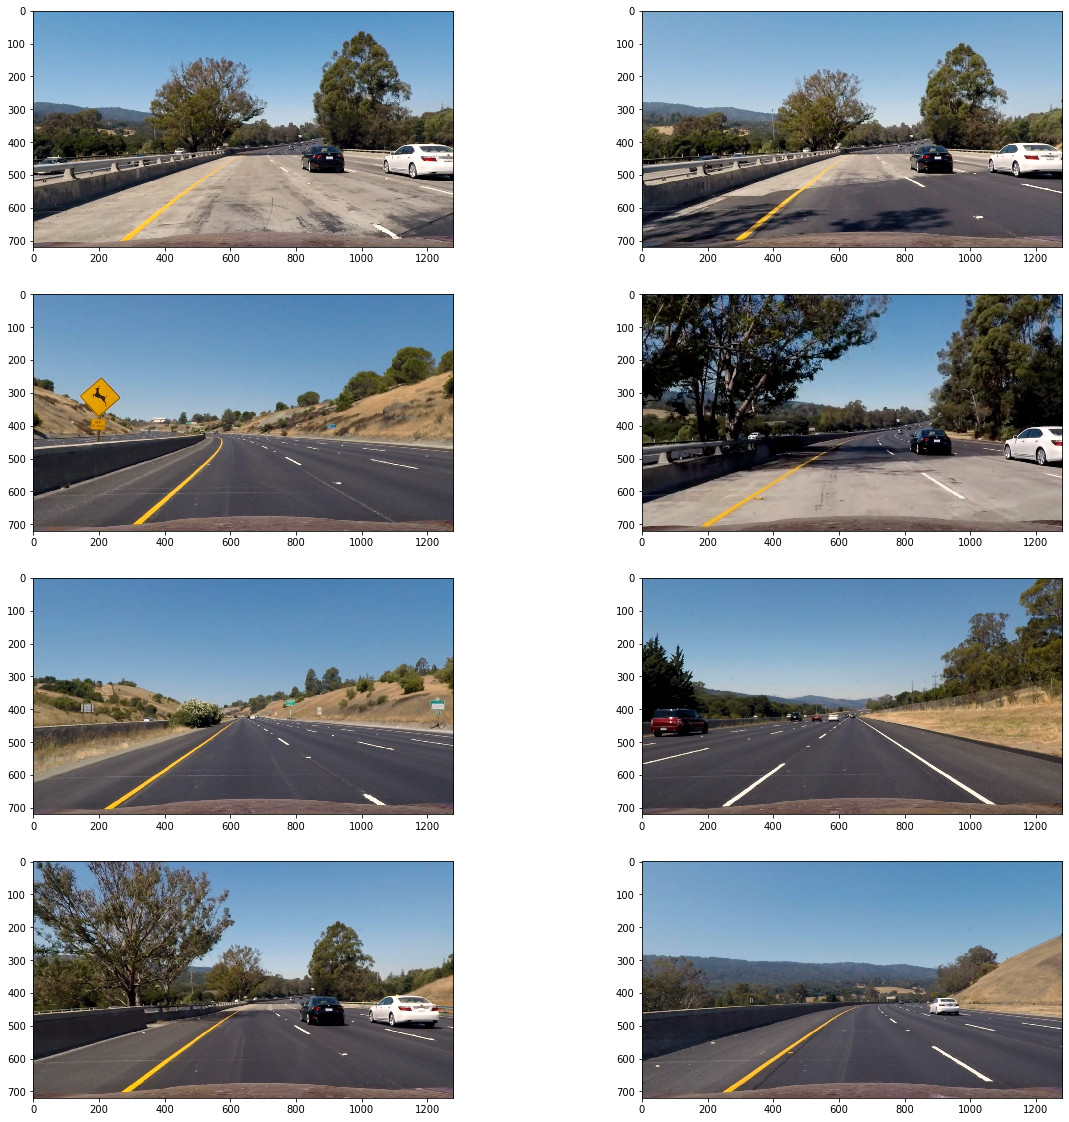

In [44]:

fig = plt.figure(figsize = (20,20))
for i in range (8):
    ax = fig.add_subplot(4,2,i+1)
    ax.imshow(undisImag[i])

### Step 3 - Threshold-out the Lanes

First, build the filters that might be used.

In [4]:
# build the filters that might be used
def sobel_abs_thresh(img, orient='x',sobel_kernel = 5,thresh=(20, 100)):
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def sobel_mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 100)):
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def sobel_dir_threshold(img, sobel_kernel= 5, thresh=(0.7, 1.3)):
    # Grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_threshold(img, colorMode = 'HLS', channel = 'S', thresh = (170, 255)):
    # experiment with different color thresholding methods
    if colorMode == 'HLS':
        image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        ChInx = {'H':0,'L':1,'S':2}
        Ch_thresh = image[:,:,ChInx[channel]]
        
    elif colorMode == 'HSV':
        image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        ChInx = {'H':0,'S':1,'V':2}
        Ch_thresh = image[:,:,ChInx[channel]]
        
    elif colorMode == 'RGB':
        ChInx = {'R':0,'G':1,'B':2}
        Ch_thresh = img[:,:,ChInx[channel]]
        
    else:
        print ("colorMode incorrrect")
        return 0
    
    # convert to 0-255
    Ch_thresh = 255 * (Ch_thresh / np.max(Ch_thresh))
    # apply threshold
    binary_output = np.zeros_like(Ch_thresh)
    binary_output[(Ch_thresh > thresh[0]) & (Ch_thresh <= thresh[1])] = 1
    
    return binary_output
        

Experiment the combinations of the filters that generates the best lane pixels.

In [7]:
def combined_thresh (img, sobel_kernel = (5,5,5), absx_thresh = (20,100), absy_thresh=(50,100),mag_thresh = (30,100),\
                     dir_thresh = (0.7,1.3), colorMode = ['HLS','RGB'], channel = ['S','R'], col_thresh =[(90,255),(200,255)] ):
    
    
    col1_binary = color_threshold(img, colorMode = colorMode[0], channel = channel[0], thresh = col_thresh[0])
    col2_binary = color_threshold(img, colorMode = colorMode[1], channel = channel[1], thresh = col_thresh[1])
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gradx = sobel_abs_thresh(gray, orient='x', sobel_kernel=sobel_kernel[0], thresh=absx_thresh)
    grady = sobel_abs_thresh(gray, orient='y', sobel_kernel=sobel_kernel[0], thresh=absy_thresh)
    mag_binary = sobel_mag_thresh(gray, sobel_kernel=sobel_kernel[1], mag_thresh=mag_thresh)
    dir_binary = sobel_dir_threshold(gray, sobel_kernel=sobel_kernel[2], thresh=dir_thresh)
    
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[((gradx == 1)) | \
                    ((mag_thresh == 1)&(dir_thresh == 1)) |\
                    ((col1_binary == 1)&(col2_binary == 1))  ] = 1
    
    return combined_binary

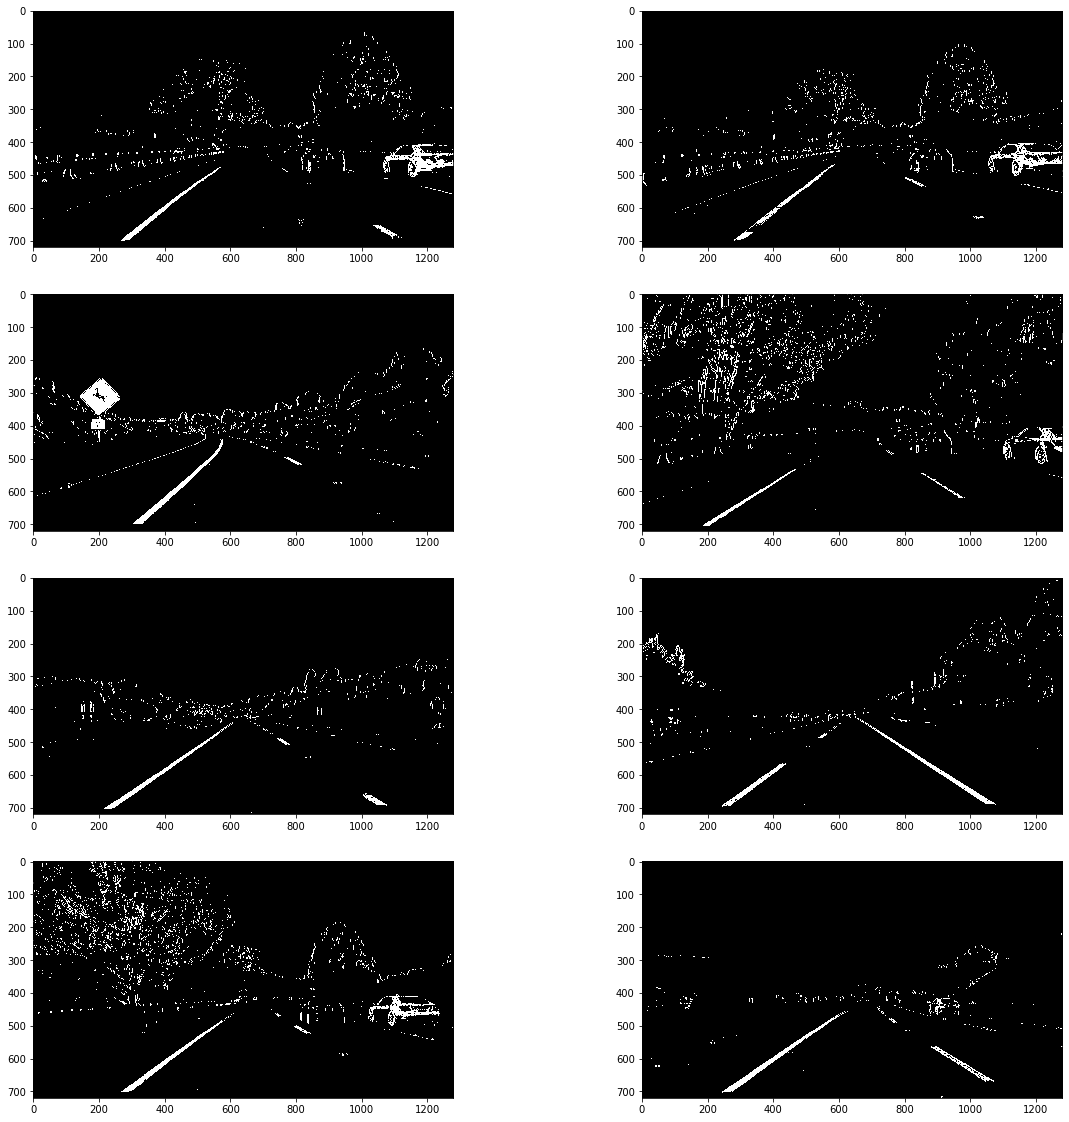

In [22]:
threshImg = []
for i in range (8):
    img = combined_thresh (undisImag[i], sobel_kernel = (5,5,15), absx_thresh = (50,255),absy_thresh=(30,200), mag_thresh = (50,255),\
                           dir_thresh = (0.7,1.3), colorMode = ['HLS','RGB'], channel = ['S','R'], col_thresh = [(170,255),(170,255)])  
    threshImg.append(img)
    
fig = plt.figure(figsize = (20,20))
for i in range (8):
    ax = fig.add_subplot(4,2,i+1)
    ax.imshow(threshImg[i],cmap = 'gray')

### Step 4 - Perspective Transformation

In [9]:
# define a function to do the perspective transformation
def warp_imag(img,dst,src):
    img_size = (img.shape[1],img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped,M,Minv

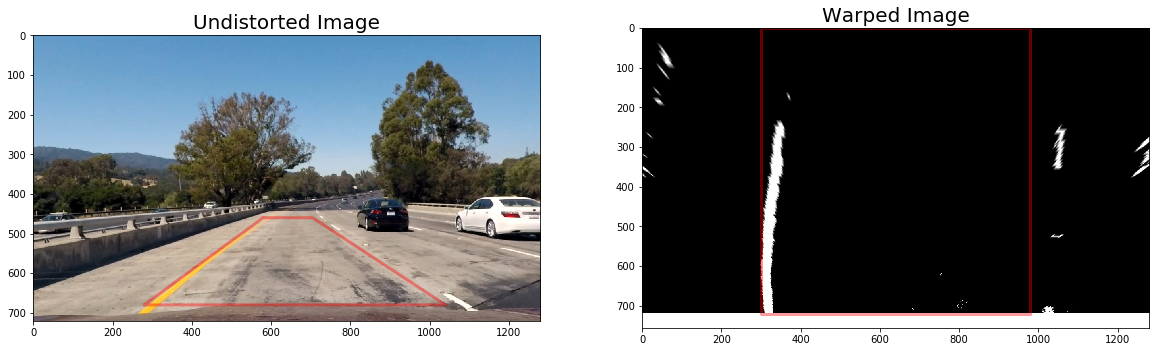

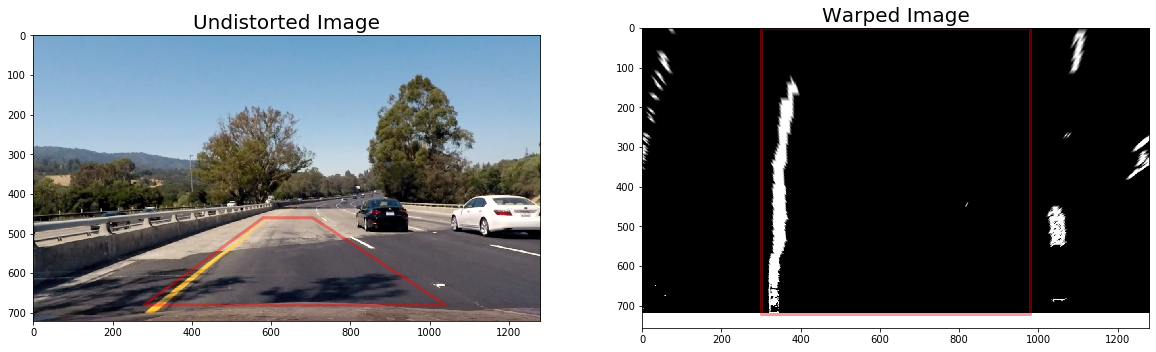

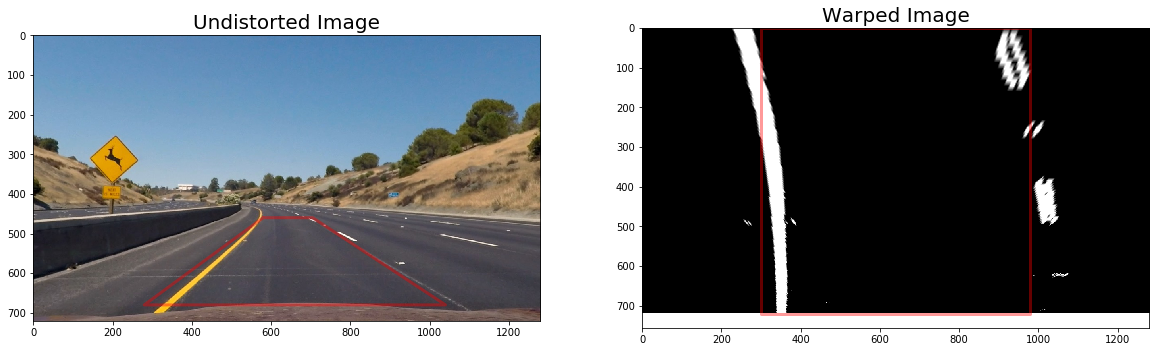

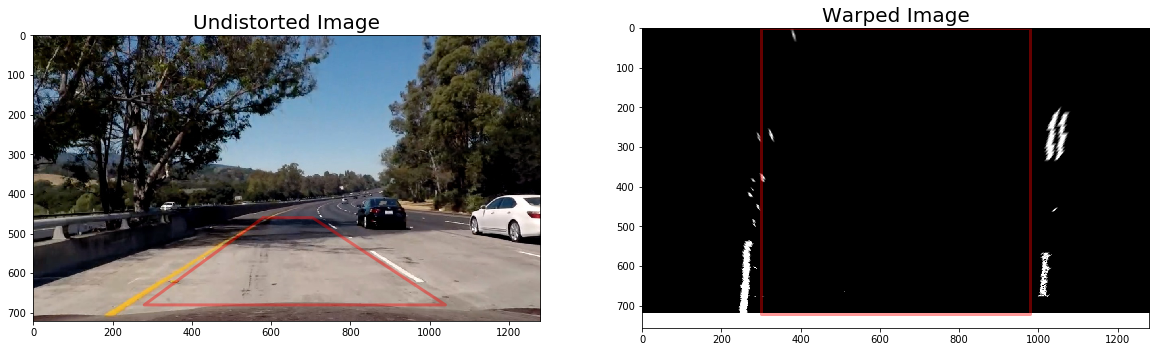

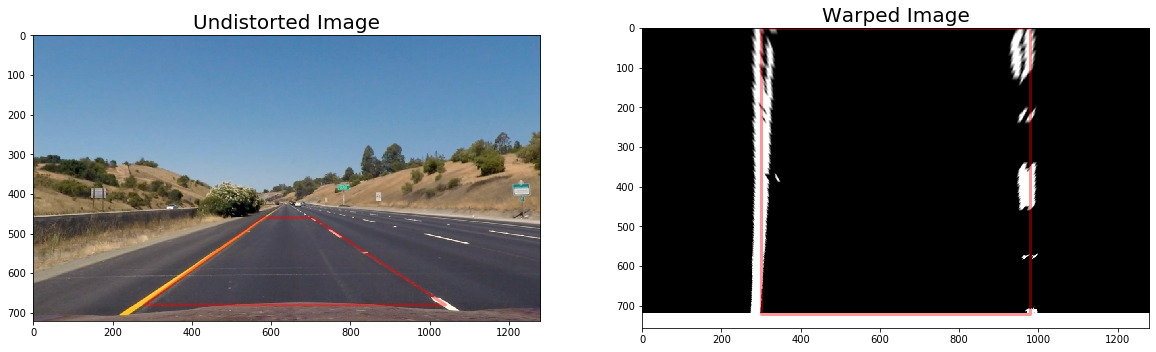

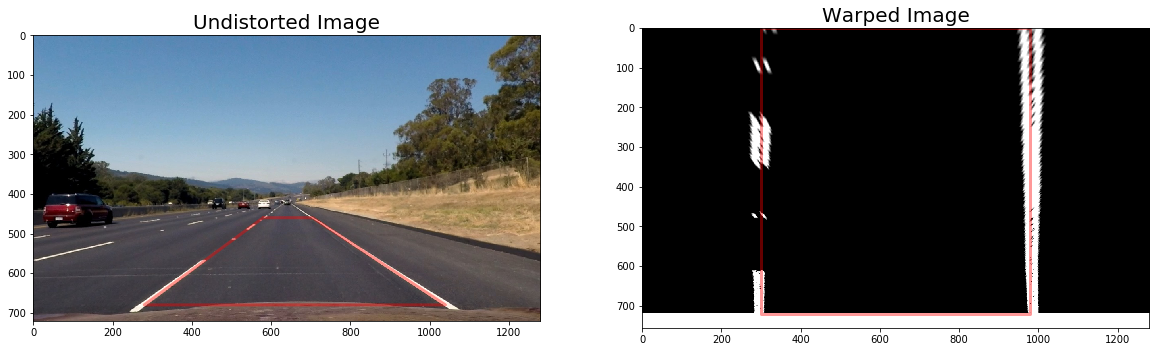

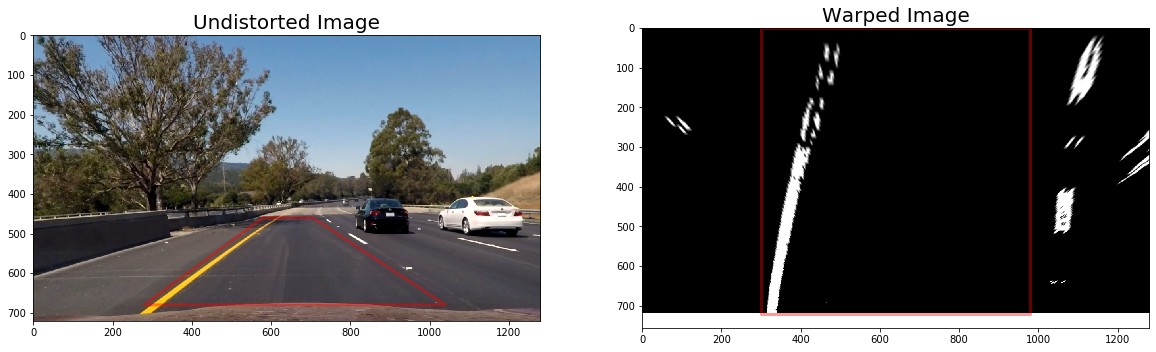

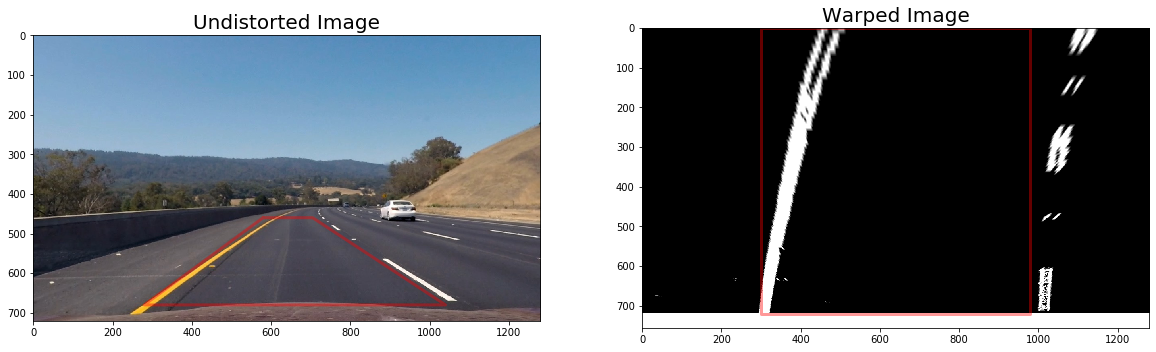

In [68]:
# define source and destination points for transform
# source points should form a trapezoidal, the destination points should be a rectangle
# find an image with straight lanes, overlap the trapezoidal on the image, then make sure the warped image
# has the rectangle aligned with the lanes

src = np.float32([(580,460),
                  (705,460), 
                  (280,680), 
                  (1040,680)])

dst = np.float32([(300,0),
                  (Width-300,0),
                  (300,720),
                  (Width-300,720)])


warpedImg = []
for i in range (8):
    
    wImg,M,Minv = warp_imag(threshImg[i],dst,src)
    warpedImg.append(wImg)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(undisImag[i],cmap='gray')
    x = [src[0][0],src[1][0],src[3][0],src[2][0],src[0][0]]
    y = [src[0][1],src[1][1],src[3][1],src[2][1],src[0][1]]
    ax1.plot(x, y, color='r', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
    ax1.set_title('Undistorted Image', fontsize=20)
    ax2.imshow(wImg,cmap='gray')
    x = [dst[0][0],dst[1][0],dst[3][0],dst[2][0],dst[0][0]]
    y = [dst[0][1],dst[1][1],dst[3][1],dst[2][1],dst[0][1]]
    ax2.plot(x, y, color='r', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
    ax2.set_title('Warped Image', fontsize=20)

### Step 5 - Curve-fit the Lanes 

If there's no exsiting polyfit coefficients, the coefficients needs to be found with Histogram, otherwise, the lane curves are fit using the coefficients from last image. First, let's see how does the first polyfit image work.

In [54]:
# define Histogram function
def Hist (binary_warped):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = binary_warped[binary_warped.shape[0]//2:,:]
    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

# define lane pixels detection
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty,out_img

# define curve fitting function
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty,out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


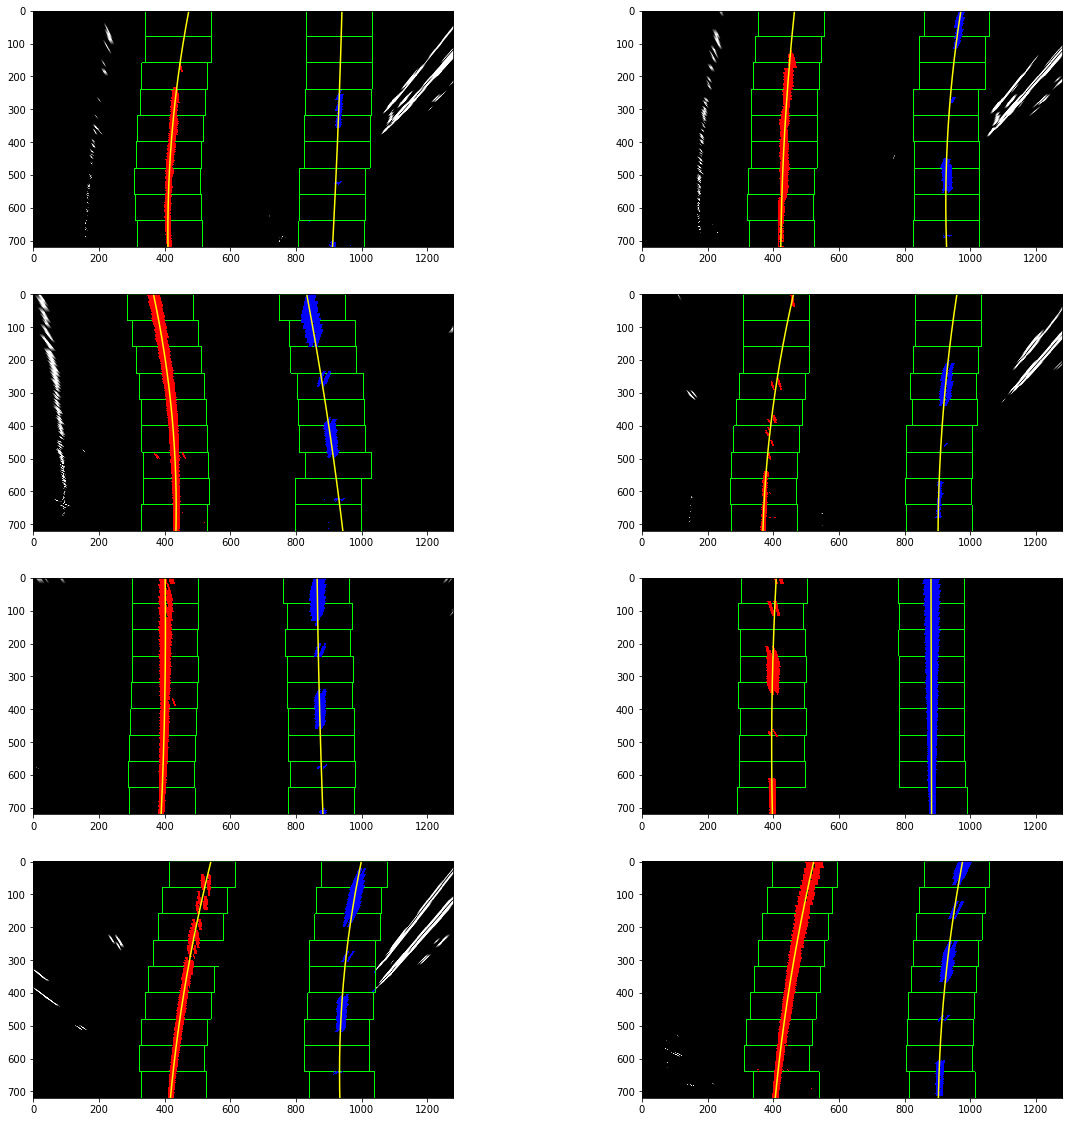

In [55]:
fig = plt.figure(figsize = (20,20))
for i in range (8):
    ax = fig.add_subplot(4,2,i+1)
    fit_img, left_fit, right_fit = fit_polynomial(warpedImg[i])
    ax.imshow(fit_img)

Now, let's deal with the following images when an inital polynomial from last image has been found.

In [13]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


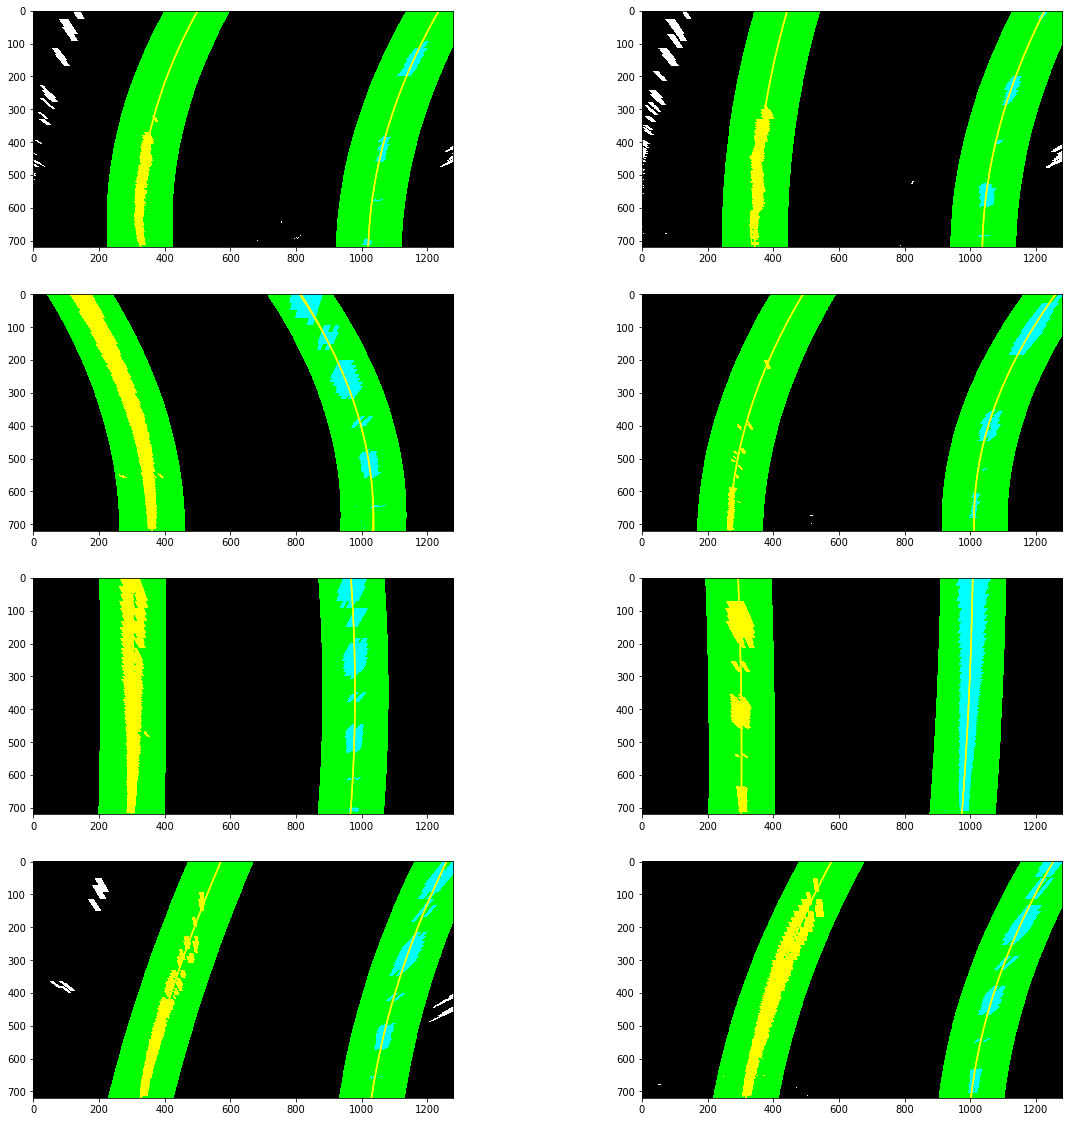

In [26]:
fig = plt.figure(figsize = (20,20))
for i in range (8):
    ax = fig.add_subplot(4,2,i+1)
    fit_img_1, left_fit, right_fit = fit_polynomial(warpedImg[i])
    fit_img_2 = search_around_poly(warpedImg[i], left_fit, right_fit)
    ax.imshow(fit_img_2)

### Step 6 - Calculate the Curvature and Car Offset

In [56]:
def measure_curvature_offset(binary_warp):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/680 # meters per pixel in x dimension
    
    # curvature of the lanes
    fit_img, left_fit_cr, right_fit_cr = fit_polynomial(binary_warp)
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = binary_warp.shape[0]
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # offset of the car
    car_center = binary_warp.shape[1]//2
    bottom_y = binary_warp.shape[0]
    bottom_x_left = left_fit_cr[0]*(bottom_y**2) + left_fit_cr[1]*bottom_y + left_fit_cr[2]
    bottom_x_right = right_fit_cr[0]*(bottom_y**2) + right_fit_cr[1]*bottom_y + right_fit_cr[2]
    vehicle_offset = car_center - (bottom_x_left + bottom_x_right)//2
    vehicle_offset *= xm_per_pix
    
    return left_curverad, right_curverad, vehicle_offset
    
    

3697.4355487106964 26788.06219850845 -0.11426470588235295
7722.925978858612 3850.94796178759 -0.19044117647058825
3247.1677156062055 11079.84284032552 -0.26117647058823534
3864.4716785554165 5097.169703013072 0.027205882352941177
12442.287458177047 27408.36074889561 0.021764705882352943
9560.994950778288 1247436.9913164258 0.005441176470588236
5043.85540836721 3279.9054103528424 -0.19588235294117648
5854.375655701546 4431.1098195816285 -0.0761764705882353


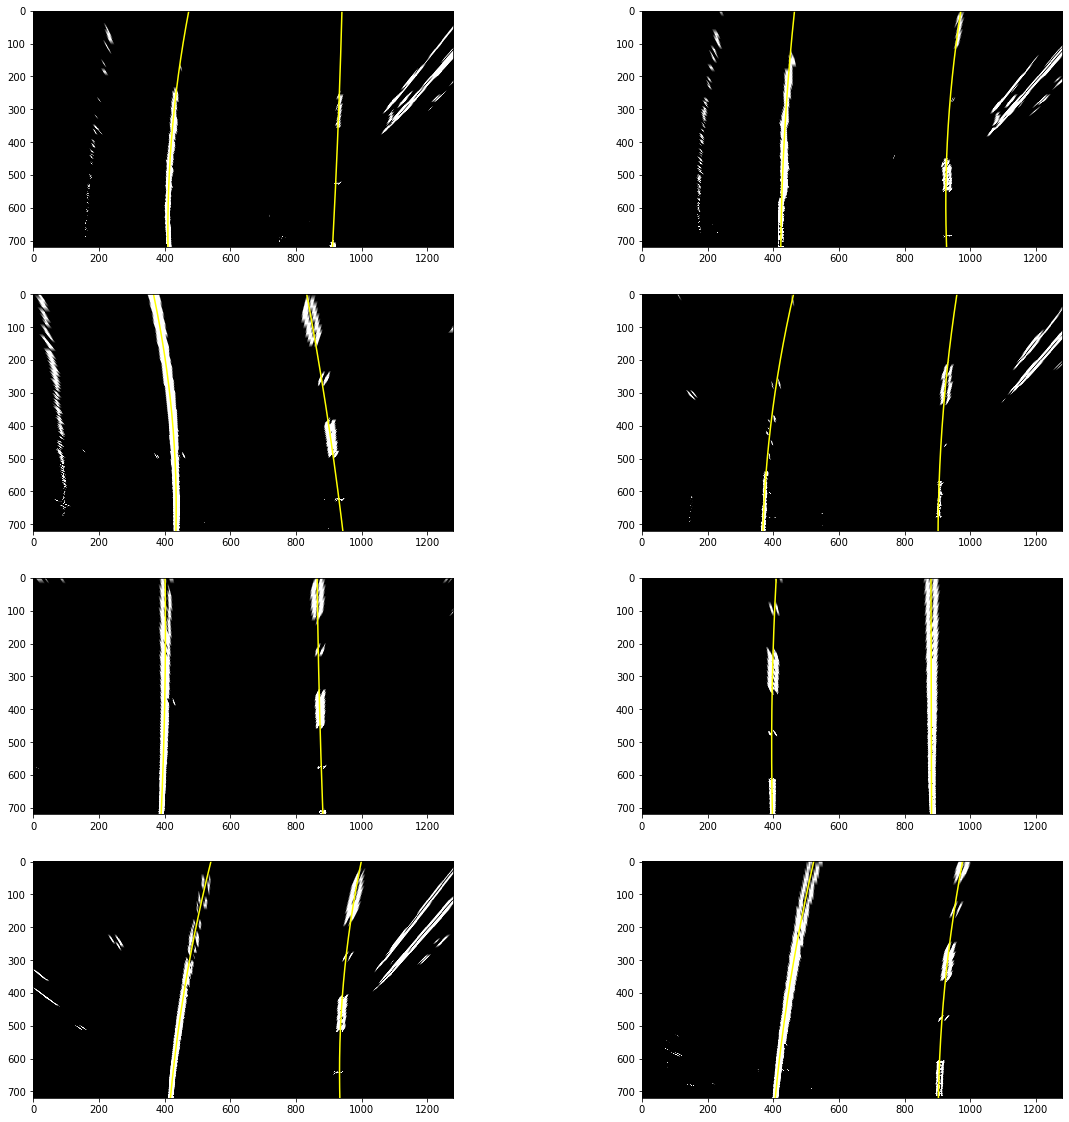

In [57]:
fig = plt.figure(figsize = (20,20))
for i in range (8):
    ax = fig.add_subplot(4,2,i+1)
    left_cur, right_cur,offset = measure_curvature_offset(warpedImg[i])
    ax.imshow(warpedImg[i],cmap='gray')
    print (left_cur,right_cur,offset)
    

### Step 7 - Draw Lanes Back to Image and Print Information

In [66]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w,h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    
    return result

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty,out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit


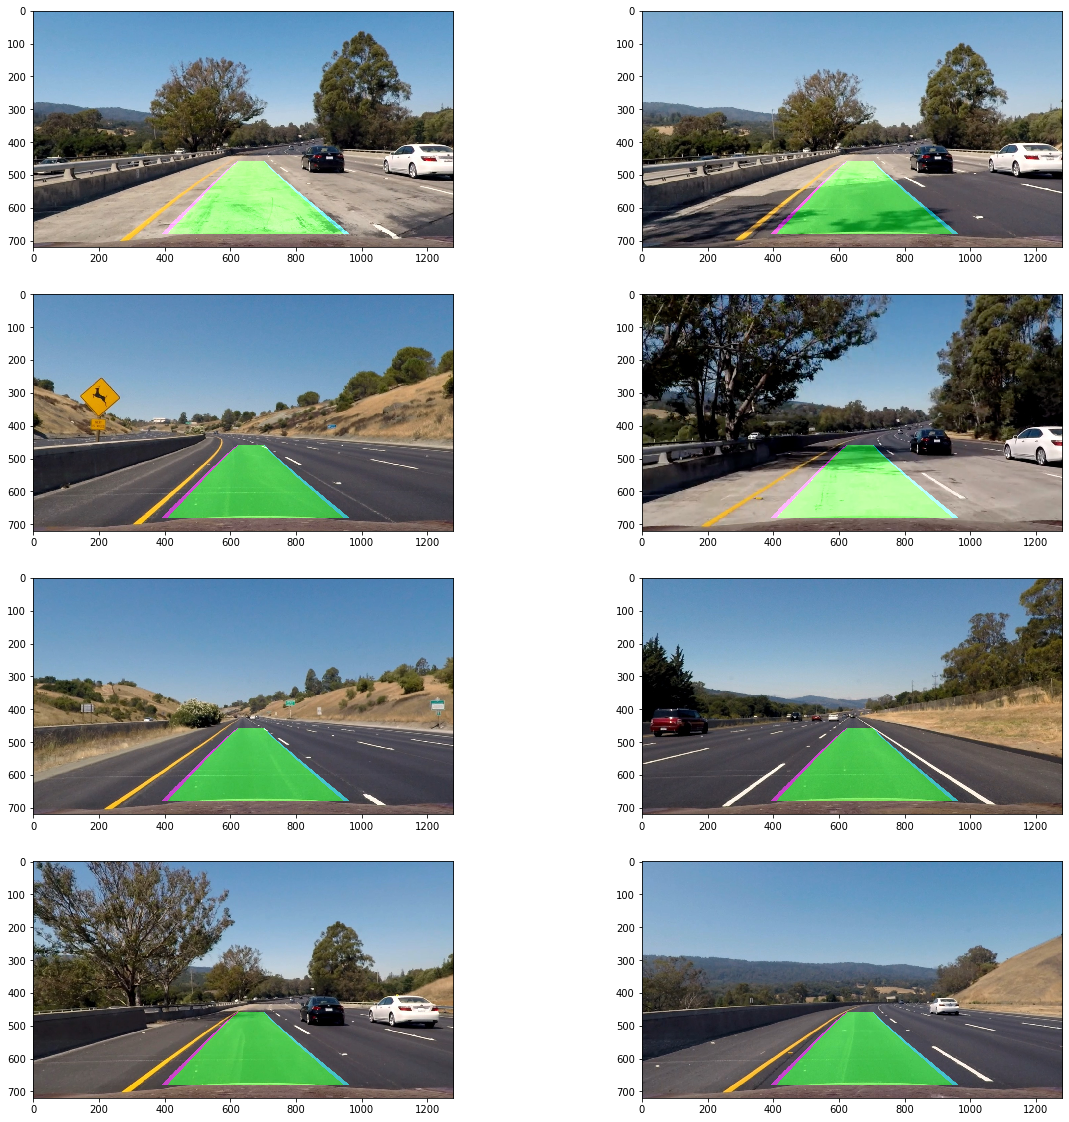

In [67]:
fig = plt.figure(figsize = (20,20))
for i in range (8):
    ax = fig.add_subplot(4,2,i+1)
    left_f,right_f = fit_polynomial(warpedImg[i])
    plt.imshow(draw_lane(undisImag[i], warpedImg[i], left_fit, right_fit, Minv))

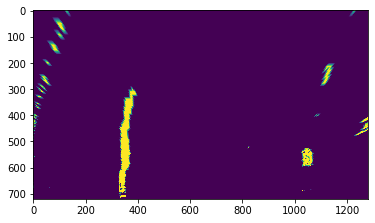

In [44]:
plt.imshow(warpedImg[1])

### Step 7 - Build the Complete Pipeline